In [50]:
%matplotlib inline
from pandas.io.parsers import read_csv
import os
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
TRAIN_DATA = '../data/training.csv'
TEST_DATA = '../data/test.csv'
IMAGE_ROWS = 96
IMAGE_COLS = 96




In [3]:
def loader(test=False, seed=None, keeplabels=None):
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    df = df.dropna() # drop rows with missing labels
    
    X = np.vstack(df['Image'])/255
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns.difference(['Image'])].values
        y = y.astype(np.float32)
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
    else:
        y = None
    
    X = X.reshape(-1, 96, 96, 1)

    return X, y


In [4]:
X, y = loader(seed=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)


In [5]:
# print((X_train.shape))
# print((y_train.shape))
print(np.sum(np.isnan(y_test)))



0


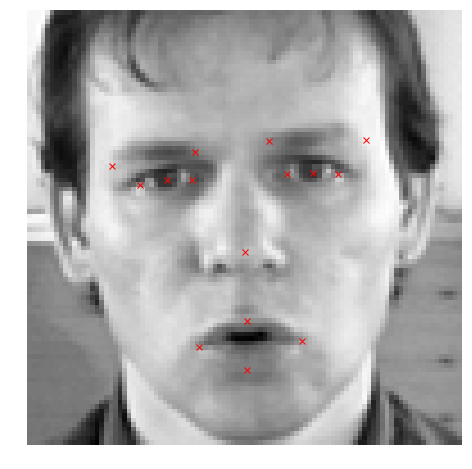

In [49]:
def plot_image(image, points):
    plt.figure(figsize=(8,8))
    plt.imshow(np.reshape(image,(96,96)), cmap = 'gray')
    
    for x, y in np.reshape(points,(len(points)//2, 2)):
        plt.plot(x, y, 'rx')
    plt.axis('off')
    
plot_image(X_train[0],y_train[0])



In [7]:
# try a LeNet Architecture - not tested yet
def make_lenet():
    input_shape = (IMAGE_ROWS, IMAGE_COLS, 1)
    LeNet = Sequential()
    LeNet.add(Conv2D(32,
                     (3, 3),
                     activation='relu',
                    input_shape=input_shape))
    LeNet.add(MaxPooling2D(pool_size=(2, 2)))
    LeNet.add(Dropout(.1))

#     LeNet.add(Conv2D(filters=64,
#                      kernel_size=(2, 2),
#                      activation='relu',
#                     input_shape=input_shape))
#     LeNet.add(MaxPooling2D(pool_size=(2, 2)))
#     LeNet.add(Dropout(.2))
    LeNet.add(Flatten())
    LeNet.add(Dense(270, activation = "relu"))
    LeNet.add(Dropout(0.5))
    LeNet.add(Dense(90, activation = "tanh"))
    LeNet.add(Dropout(0.5))
    LeNet.add(Dense(30))
    
    return LeNet


In [34]:
def fit_model(model=None, data=None):
    learning_rate = .001
    epochs = 10
    if not data:
        print('getting data')
        X, y = loader(seed=42)
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)
    elif len(data)==4:
        X_train = data[0]
        X_test = data[1]
        y_train = data[2]
        y_test = data[3]
    else:
        raise ValueError('unexpected data input')
        
    if not model:
        model = make_lenet()
   # sgd = SGD(lr=learning_rate, momentum=0.9, nesterov=True)
    model.compile(loss='mse', optimizer='sgd')
    # change_lr = LearningRateScheduler(lambda epoch: float(learning_rate[epoch]))

    # flipgen = FlippedImageDataGenerator()
#     hist = model.fit_generator(X_train, y_train,
#                             steps_per_epoch=X_train.shape[0],
#                             nb_epoch=epochs,
#                             validation_data=(X_test, y_test),
#                             callbacks=[early_stop])

    model.fit(X_train, y_train, epochs=epochs, batch_size=100,
             validation_data=(X_test, y_test)
             )

In [52]:
# def plot_loss():
#     loss = np.loadtxt('my_cnn_model_loss.csv')
#     val_loss = np.loadtxt('my_cnn_model_val_loss.csv')

#     plt.plot(loss, linewidth=3, label='train')
#     plt.plot(val_loss, linewidth=3, label='valid')
#     plt.grid()
#     plt.legend()
#     plt.xlabel('epoch')
#     plt.ylabel('loss')
#     plt.ylim(1e-3, 1e-2)
#     plt.yscale('log')
#     plt.show()

In [33]:
X, y = loader(seed=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
data=[X_train, X_test, y_train, y_test]

In [35]:
input_shape=(IMAGE_ROWS, IMAGE_COLS, 1)

model = Sequential()
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 strides=(1,1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(30, activation = "tanh")) #changed to tanh because relu blew up
model.add(Dense(30))
fit_model(model=model,data=data)

Train on 1712 samples, validate on 428 samples
Epoch 1/10
1712/1712 [==============================] - 7s 4ms/step - loss: 1936.2233 - val_loss: 1265.8558
Epoch 2/10
1712/1712 [==============================] - 7s 4ms/step - loss: 919.4686 - val_loss: 603.5109
Epoch 3/10
1712/1712 [==============================] - 7s 4ms/step - loss: 438.5161 - val_loss: 291.0625
Epoch 4/10
1712/1712 [==============================] - 7s 4ms/step - loss: 212.1195 - val_loss: 143.5686
Epoch 5/10
1712/1712 [==============================] - 7s 4ms/step - loss: 105.5383 - val_loss: 73.4051
Epoch 6/10
1712/1712 [==============================] - 7s 4ms/step - loss: 55.0553 - val_loss: 40.2630
Epoch 7/10
1712/1712 [==============================] - 7s 4ms/step - loss: 31.3646 - val_loss: 24.5322
Epoch 8/10
1712/1712 [==============================] - 7s 4ms/step - loss: 20.2175 - val_loss: 16.9435
Epoch 9/10
1712/1712 [==============================] - 7s 4ms/step - loss: 14.9043 - val_loss: 13.3101
Epoch 

In [ ]:
keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid',
                    data_format=None, dilation_rate=(1, 1), activation=None,
                    use_bias=True, kernel_initializer='glorot_uniform',
                    bias_initializer='zeros', kernel_regularizer=None,
                    bias_regularizer=None, activity_regularizer=None,
                    kernel_constraint=None, bias_constraint=None)

keras.layers.Dense(units, activation=None, use_bias=True, 
                   kernel_initializer='glorot_uniform', 
                   bias_initializer='zeros', kernel_regularizer=None, 
                   bias_regularizer=None, activity_regularizer=None, 
                   kernel_constraint=None, bias_constraint=None)

keras.layers.Dropout(rate, noise_shape=None, seed=None)


In [22]:
print(y_train.shape)

(1712, 30)
